# Dacon progect: Prediction Model of Crime Prevention

## Setting

### install

In [1]:
# pip install pandas
# pip install seaborn
# pip install scikit-learn
# pip install optuna
#!pip install lightgbm

### import


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import os

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

c:\Users\lab\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### seed 고정


In [3]:
#seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [4]:
#한글 세팅
fe = fm.FontEntry(fname = 'NanumBarunGothic.ttf', name = 'NanumBarunGothic')

fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='NanumBarunGothic')

### data load

In [5]:
# test data
DATA = pd.read_csv('train.csv')

# test data load
TEST = pd.read_csv('test.csv')

# label data load : 범죄발생구역 중에서 비슷한 범죄항목 비율이 있는 지역끼리 대구분을 해 보았음
LABEL = pd.read_csv('label.csv')

# day data load : 요일을 월 ~ 일 까지 0~6으로 구분함
DAY = pd.read_csv('day.csv')

#train.head(3)
#label.head(5)

## data EDA

### 범죄발생지역 대구분 - 데이터 머지

In [6]:
DATA = pd.merge(left=DATA, right=LABEL, left_on='범죄발생지', right_on='구역')
DATA.drop(columns=['구역', 'ID'], inplace=True)

TEST = pd.merge(left=TEST, right=LABEL, left_on='범죄발생지', right_on='구역')
TEST.drop(columns=['구역', 'ID'], inplace=True)


In [7]:
'''
여러개를 기준으로 머지 시킬때는 리스트 형태를 취한다.
마소 엑세스의 테이블끼리 조인해서 쿼리문을 만들때, 화살표와 같은 것!

 data = pd.merge(left=original, right=label, 
                left_on=['data', 'cadavercode'],
                right_on=['date', 'cadavercode']
                )
'''

"\n여러개를 기준으로 머지 시킬때는 리스트 형태를 취한다.\n마소 엑세스의 테이블끼리 조인해서 쿼리문을 만들때, 화살표와 같은 것!\n\n data = pd.merge(left=original, right=label, \n                left_on=['data', 'cadavercode'],\n                right_on=['date', 'cadavercode']\n                )\n"

In [8]:
DATA.head(5)

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,대구분
0,9,화요일,10,137,8.0,2.611124,0.000000,0.0,0.000000,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311
1,11,화요일,6,438,13.0,3.209093,0.000000,0.0,0.000000,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,2311
2,8,목요일,8,1846,36.0,2.321947,3.250000,0.0,0.000000,120.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,차도,1,2311
3,7,월요일,2,1747,46.0,1.453440,0.000000,0.0,0.000000,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311
4,1,일요일,9,1347,36.0,1.631310,2.571429,1.5,4.333333,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311


In [9]:
TEST.head(5)

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,대구분
0,9,금요일,5,927,28.0,1.570654,19.625,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도,2311
1,2,월요일,12,848,24.0,2.546165,39.875,12.0,416.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,차도,2311
2,5,금요일,12,1149,29.0,1.996479,0.000,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2311
3,6,화요일,6,548,13.0,3.829857,61.800,0.0,0.0,315.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도,2311
4,9,수요일,9,2149,38.0,2.021118,0.000,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,차도,2311


### 요일 대구분 - 데이터 머지

In [10]:
DATA = pd.merge(left=DATA, right=DAY, left_on='요일', right_on='요일')
TEST = pd.merge(left=TEST, right=DAY, left_on='요일', right_on='요일')

# 중복 컬럼 데이터 드롭
DATA.drop(columns=['요일'], inplace=True)
TEST.drop(columns=['요일'], inplace=True)


In [11]:
DATA.head(5)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,대구분,day
0,9,10,137,8.0,2.611124,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311,1
1,11,6,438,13.0,3.209093,0.000000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,2311,1
2,6,12,1438,41.0,1.291232,2.428571,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,2311,1
3,9,3,538,10.0,1.543076,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,2311,1
4,6,1,338,11.0,4.133959,0.000000,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311,1


In [12]:
TEST.head(5)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,대구분,day
0,9,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,차도,2311,4
1,5,12,1149,29.0,1.996479,0.000000,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2311,4
2,2,10,526,21.0,1.820317,56.500000,25.5,279.2,255.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,차도,2311,4
3,10,3,1037,31.0,2.124890,6.857143,0.0,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2311,4
4,7,3,2339,53.0,0.754256,130.800000,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2311,4


### 범주형 데이터 라벨링

In [13]:
'''cat_feature = ['범죄발생지']

for i in cat_feature:
        
    le = LabelEncoder()

    # 범죄발생지를 LabelEncoder 의 fit_transform 에 넣어준다
    le.fit_transform(DATA[i].unique())

    new_cat = i+"2"
    # 적용!
    DATA[new_cat] = le.transform(DATA[i])
    DATA.drop(columns=i, inplace=True)


for i in cat_feature:
        
    le = LabelEncoder()

    # 범죄발생지를 LabelEncoder 의 fit_transform 에 넣어준다
    le.fit_transform(TEST[i].unique())

    new_cat = i+"2"
    # 적용!
    TEST[new_cat] = le.transform(TEST[i])
    TEST.drop(columns=i, inplace=True)
    '''

'cat_feature = [\'범죄발생지\']\n\nfor i in cat_feature:\n        \n    le = LabelEncoder()\n\n    # 범죄발생지를 LabelEncoder 의 fit_transform 에 넣어준다\n    le.fit_transform(DATA[i].unique())\n\n    new_cat = i+"2"\n    # 적용!\n    DATA[new_cat] = le.transform(DATA[i])\n    DATA.drop(columns=i, inplace=True)\n\n\nfor i in cat_feature:\n        \n    le = LabelEncoder()\n\n    # 범죄발생지를 LabelEncoder 의 fit_transform 에 넣어준다\n    le.fit_transform(TEST[i].unique())\n\n    new_cat = i+"2"\n    # 적용!\n    TEST[new_cat] = le.transform(TEST[i])\n    TEST.drop(columns=i, inplace=True)\n    '

In [14]:
DATA.loc[DATA['범죄발생지'] == '공원', '범죄발생지'] = 442
DATA.loc[DATA['범죄발생지'] == '백화점', '범죄발생지'] = 190
DATA.loc[DATA['범죄발생지'] == '병원', '범죄발생지'] = 631
DATA.loc[DATA['범죄발생지'] == '식당', '범죄발생지'] = 532
DATA.loc[DATA['범죄발생지'] == '약국', '범죄발생지'] = 180
DATA.loc[DATA['범죄발생지'] == '은행', '범죄발생지'] = 523
DATA.loc[DATA['범죄발생지'] == '인도', '범죄발생지'] = 712
DATA.loc[DATA['범죄발생지'] == '주거지', '범죄발생지'] = 522
DATA.loc[DATA['범죄발생지'] == '주유소', '범죄발생지'] = 533
DATA.loc[DATA['범죄발생지'] == '주차장', '범죄발생지'] = 343
DATA.loc[DATA['범죄발생지'] == '차도', '범죄발생지'] = 334
DATA.loc[DATA['범죄발생지'] == '편의점', '범죄발생지'] = 271
DATA.loc[DATA['범죄발생지'] == '학교', '범죄발생지'] = 622
DATA.loc[DATA['범죄발생지'] == '호텔/모텔', '범죄발생지'] = 531

In [15]:
DATA['범죄발생지'] = DATA['범죄발생지'].astype(int)
DATA.dtypes

월            int64
시간           int64
소관경찰서        int64
소관지역       float64
사건발생거리     float64
강수량(mm)    float64
강설량(mm)    float64
적설량(cm)    float64
풍향         float64
안개         float64
짙은안개       float64
번개         float64
진눈깨비       float64
서리         float64
연기/연무      float64
눈날림        float64
범죄발생지        int32
TARGET       int64
대구분          int64
day          int64
dtype: object

In [16]:
TEST.loc[TEST['범죄발생지'] == '공원', '범죄발생지'] = 442
TEST.loc[TEST['범죄발생지'] == '백화점', '범죄발생지'] = 190
TEST.loc[TEST['범죄발생지'] == '병원', '범죄발생지'] = 631
TEST.loc[TEST['범죄발생지'] == '식당', '범죄발생지'] = 532
TEST.loc[TEST['범죄발생지'] == '약국', '범죄발생지'] = 180
TEST.loc[TEST['범죄발생지'] == '은행', '범죄발생지'] = 523
TEST.loc[TEST['범죄발생지'] == '인도', '범죄발생지'] = 712
TEST.loc[TEST['범죄발생지'] == '주거지', '범죄발생지'] = 522
TEST.loc[TEST['범죄발생지'] == '주유소', '범죄발생지'] = 533
TEST.loc[TEST['범죄발생지'] == '주차장', '범죄발생지'] = 343
TEST.loc[TEST['범죄발생지'] == '차도', '범죄발생지'] = 334
TEST.loc[TEST['범죄발생지'] == '편의점', '범죄발생지'] = 271
TEST.loc[TEST['범죄발생지'] == '학교', '범죄발생지'] = 622
TEST.loc[TEST['범죄발생지'] == '호텔/모텔', '범죄발생지'] = 531

In [17]:
TEST['범죄발생지'] = TEST['범죄발생지'].astype(int)
TEST.dtypes

월            int64
시간           int64
소관경찰서        int64
소관지역       float64
사건발생거리     float64
강수량(mm)    float64
강설량(mm)    float64
적설량(cm)    float64
풍향         float64
안개         float64
짙은안개       float64
번개         float64
진눈깨비       float64
서리         float64
연기/연무      float64
눈날림        float64
범죄발생지        int32
대구분          int64
day          int64
dtype: object

In [18]:
DATA.head(5)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,대구분,day
0,9,10,137,8.0,2.611124,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,2,2311,1
1,11,6,438,13.0,3.209093,0.000000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,0,2311,1
2,6,12,1438,41.0,1.291232,2.428571,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,0,2311,1
3,9,3,538,10.0,1.543076,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,0,2311,1
4,6,1,338,11.0,4.133959,0.000000,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,2,2311,1


In [19]:

TEST.head(5)

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,대구분,day
0,9,5,927,28.0,1.570654,19.625000,0.0,0.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,334,2311,4
1,5,12,1149,29.0,1.996479,0.000000,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,2311,4
2,2,10,526,21.0,1.820317,56.500000,25.5,279.2,255.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,334,2311,4
3,10,3,1037,31.0,2.124890,6.857143,0.0,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334,2311,4
4,7,3,2339,53.0,0.754256,130.800000,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,334,2311,4


In [20]:
# f_data.info()
# test.info()

In [21]:
# 기술통계량을 확인하기위해 describe() 함수를 사용합니다.  
DATA.describe()

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,대구분,day
count,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000
mean,6.430195,6.769507,1060.027581,26.881726,1.912424,24.608776,2.284407,23.430503,186.926107,0.385423,0.017842,0.144042,0.020330,0.010260,0.210755,0.008921,450.235730,0.835355,1684.691681,3.091700
std,3.108302,3.566390,698.380485,13.870968,0.958556,62.711211,15.852881,85.199896,98.299485,0.486698,0.132379,0.351134,0.141128,0.100771,0.407847,0.094030,127.874156,0.819762,514.057958,2.016831
min,1.000000,1.000000,26.000000,5.000000,0.012269,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,1230.000000,0.000000
25%,4.000000,4.000000,526.000000,13.000000,1.209985,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,1230.000000,1.000000
50%,7.000000,7.000000,937.000000,27.000000,1.822279,0.625000,0.000000,0.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,522.000000,1.000000,1321.000000,3.000000
75%,9.000000,10.000000,1638.000000,38.000000,2.476528,18.571429,0.000000,0.000000,260.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,522.000000,2.000000,2311.000000,5.000000
max,12.000000,12.000000,2450.000000,54.000000,4.998936,614.875000,295.000000,649.800000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,712.000000,2.000000,2311.000000,6.000000


In [23]:
# 범죄발생지의 등장 빈도를 확인하는 코드입니다.  
DATA['범죄발생지'].value_counts()

범죄발생지
522    36077
334    25879
712     6437
271     4835
343     3262
532     1806
190     1493
533     1324
442      736
622      728
180      653
531      591
631      453
523      132
Name: count, dtype: int64

### visualization

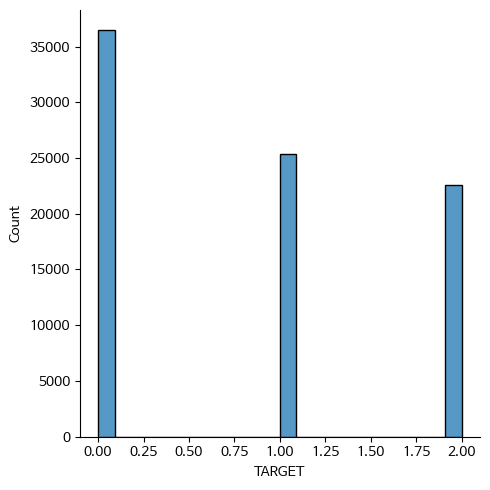

In [24]:
# 종속변수 분포 확인
sns.displot(DATA['TARGET'])

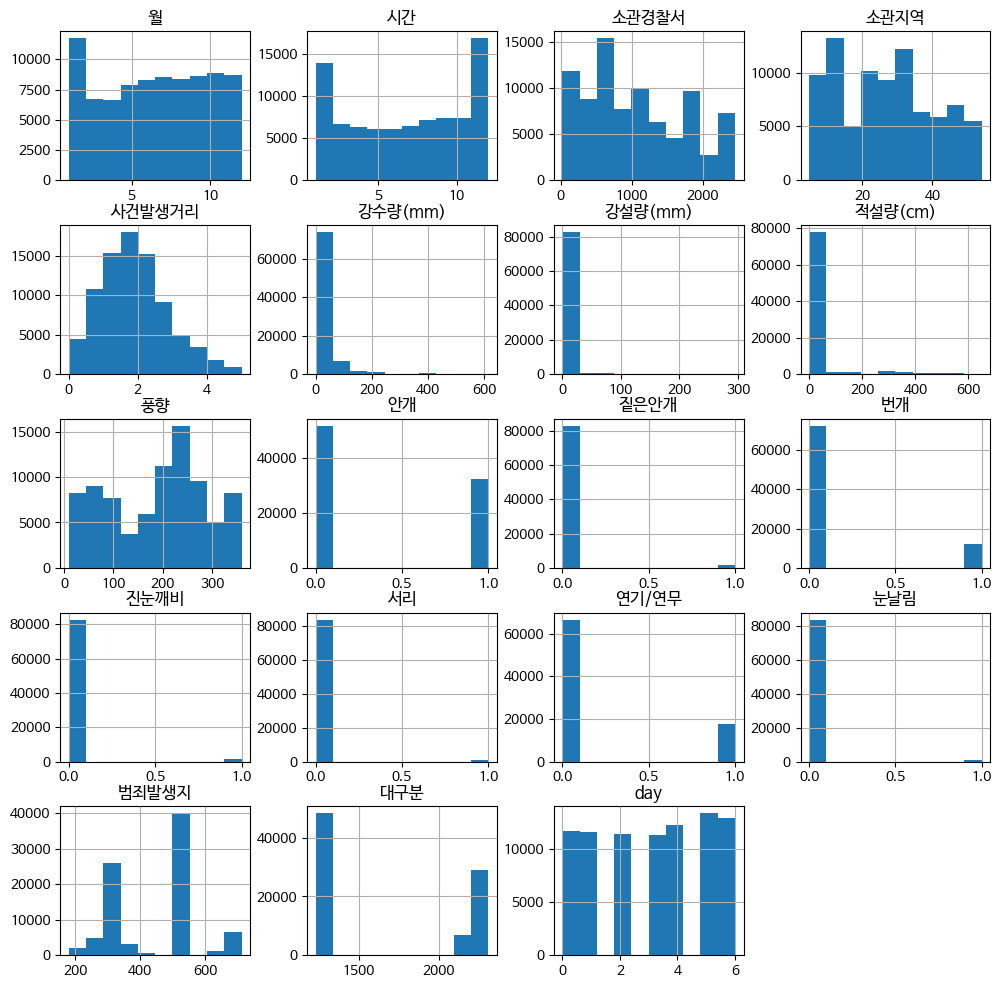

In [25]:
# 전체 데이터 분포 확인
except_target = DATA.drop('TARGET', axis = 1)
except_target.hist(figsize = (12,12))
plt.show()

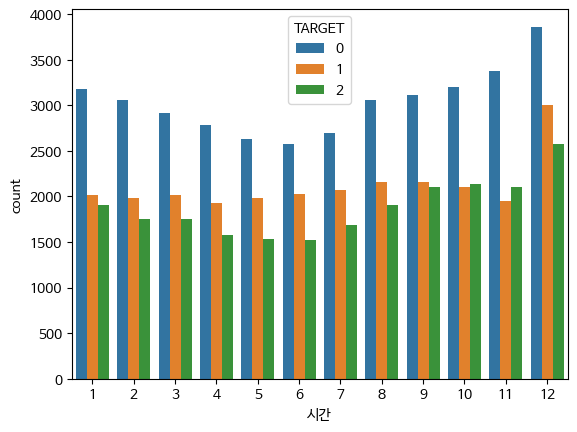

In [26]:
# 시간대별 발생 범죄 빈도 확인
sns.countplot(x = '시간', hue = 'TARGET', data = DATA)
plt.show()

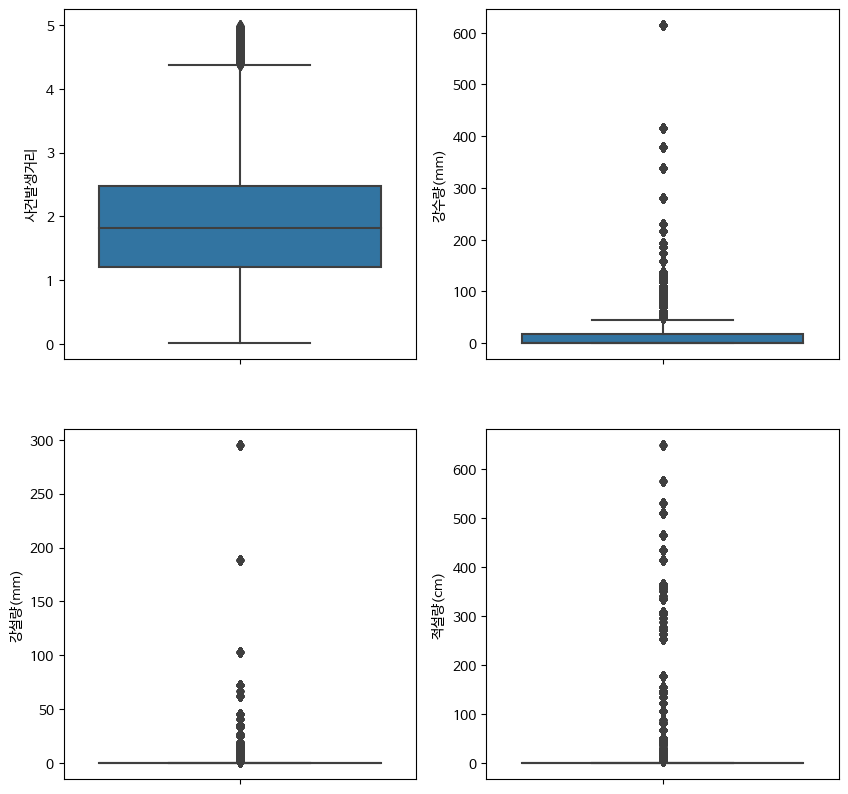

In [27]:
# 이상치 확인
fig, axes = plt.subplots(2,2, figsize = (10,10))

sns.boxplot(y = DATA['사건발생거리'], ax = axes[0][0])
sns.boxplot(y = DATA['강수량(mm)'], ax = axes[0][1])

sns.boxplot(y = DATA['강설량(mm)'], ax = axes[1][0])
sns.boxplot(y = DATA['적설량(cm)'], ax = axes[1][1])

plt.show()

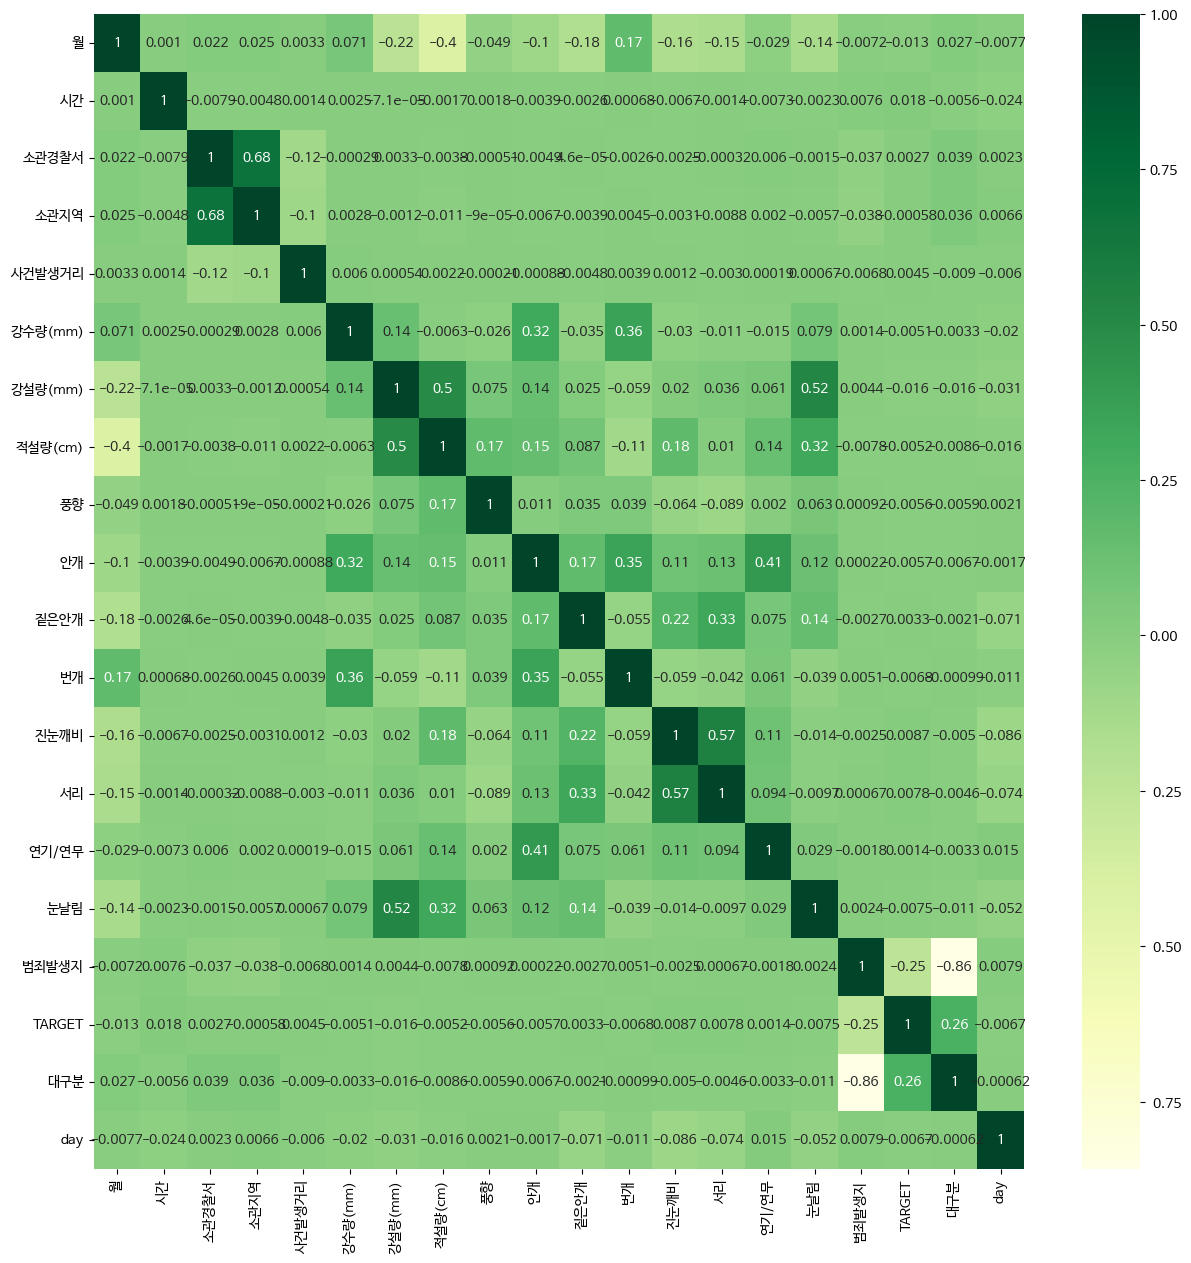

In [28]:
# 상관관계 확인
plt.figure(figsize = (15,15), dpi = 100)
sns.heatmap(DATA.corr(), annot = True, cmap = 'YlGn')
plt.show()

## Model: Decision Tree Regression

### 독립변수(x_train), 종속변수(y_train) 분리

In [29]:
# 독립변수(x_train), 종속변수(y_train) 분리
X = DATA.drop('TARGET', axis=1)
y = DATA['TARGET']

x_test = TEST

### 모델 정의

In [30]:
# data  split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [31]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
        

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [32]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-05-22 15:04:13,403] A new study created in memory with name: lgbm_parameter_opt
[I 2023-05-22 15:04:16,466] Trial 0 finished with value: 0.9630797662058938 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.9630797662058938.
[I 2023-05-22 15:04:19,079] Trial 1 finished with value: 0.9635274527665916 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 0 with value: 0.9630797662058938.
[I 2023-05-22 15:04:22,277] Trial 2 finished with value: 0.9629568286948165 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.9591628511572694
Best trial: {'reg_alpha': 7.526669770455994e-06, 'reg_lambda': 0.007315347513554999, 'max_depth': 20, 'num_leaves': 158, 'colsample_bytree': 0.49294962342814835, 'subsample': 0.940374807411319, 'subsample_freq': 2, 'min_child_samples': 26, 'max_bin': 419}


In [33]:
PARAMS = study.best_trial.params
model = LGBMClassifier(**PARAMS)

In [34]:
# 모델 학습
model.fit(X, y)

LGBMClassifier(colsample_bytree=0.49294962342814835, max_bin=419, max_depth=20,
               min_child_samples=26, num_leaves=158,
               reg_alpha=7.526669770455994e-06, reg_lambda=0.007315347513554999,
               subsample=0.940374807411319, subsample_freq=2)

### 예측

In [35]:
# 예측
y_pred = model.predict(x_test)


In [36]:
y_pred

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [37]:
# 예측
y_pred = model.predict(x_test)

## 파일 저장

In [38]:
# 파일 저장
submit = pd.read_csv('sample_submission.csv')

# 예측한 값을 TARGET 컬럼에 할당
submit['TARGET'] = y_pred
submit.head(15)

,ID,TARGET
0,TEST_00000,2
1,TEST_00001,2
2,TEST_00002,2
3,TEST_00003,0
4,TEST_00004,1
5,TEST_00005,2
6,TEST_00006,0
7,TEST_00007,2
8,TEST_00008,1
9,TEST_00009,2


In [39]:
submit.to_csv('submit2.csv', index = False)